In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **[1] Import Packages**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from tqdm import tqdm
from urllib.parse import urlparse
pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
%matplotlib inline

# **[2] Reading Data**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Project_Web_Page_Classification/webpage data.csv")

In [ ]:
df.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exec-departs-troubled-endo-and-time-it-s-for-another-drugmaker,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-biosim-specialist-celltrion-it-wouldn-t-say-no,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-marissa-tomei-partners-allergan-restasis-to-drive-dry-eye-awareness,news


In [ ]:
#finding out the shape of the data using "shape" variable: Output (rows, columns)
df.shape

(53229, 4)

In [ ]:
#Printing all the columns present in data
df.columns

Index(['Webpage_id', 'Domain', 'Url', 'Tag'], dtype='object')

# **[3] Basic Exploration**

## **[3.1] Missing values**

In [ ]:
# finding number of missing values in every variable
df.isnull().sum()

Webpage_id    0
Domain        0
Url           0
Tag           0
dtype: int64

## **[3.2] Let us have a look at a few samples from each category of target variable**

In [ ]:
df['Tag'].unique()

array(['news', 'clinicalTrials', 'conferences', 'profile', 'forum',
       'publication', 'thesis', 'guidelines', 'others'], dtype=object)

#### Public Profiles

In [ ]:
df[df['Tag'] == 'profile'].head(2)

,Webpage_id,Domain,Url,Tag
3476,5096,www.healthcare4ppl.com,http://www.healthcare4ppl.com/physician/wisconsin/waukesha/andrew-v-beykovsky-1114036092.html,profile
3477,5097,www.healthcare4ppl.com,http://www.healthcare4ppl.com/physician/west-virginia/morgantown/clare-m-mcdaniel-1346231032.html,profile


#### Conferences/Congress

In [ ]:
df[df['Tag'] == 'conferences'].head(2)

,Webpage_id,Domain,Url,Tag
550,1028,investors.alphatecspine.com,http://investors.alphatecspine.com/events.cfm,conferences
1033,1773,ir.alk.net,http://ir.alk.net/events.cfm,conferences


#### Forum

In [ ]:
df[df['Tag'] == 'forum'].head(2)

,Webpage_id,Domain,Url,Tag
3689,5549,community.beatingbowelcancer.org,http://community.beatingbowelcancer.org/forum/926-post-op,forum
3765,5714,rollitup.org,http://rollitup.org/t/someguys-led-other-grows-2014-15-season.851562/page-82,forum


#### News Articles

In [ ]:
df[df['Tag'] == 'news'].head(2)

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news


#### Clinical Trials

In [ ]:
df[df['Tag'] == 'clinicalTrials'].head(2)

,Webpage_id,Domain,Url,Tag
30,36,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018186,clinicalTrials
31,39,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018428,clinicalTrials


#### Publications

In [ ]:
df[df['Tag'] == 'publication'].head(2)

,Webpage_id,Domain,Url,Tag
4164,6295,jvi.asm.org,http://jvi.asm.org/content/87/9/4994.long,publication
4165,6296,iai.asm.org,http://iai.asm.org/content/77/7/3033.long,publication


#### Thesis

In [ ]:
df[df['Tag'] == 'thesis'].head(2)

,Webpage_id,Domain,Url,Tag
5118,7526,ecommons.cornell.edu,https://ecommons.cornell.edu/handle/1813/29484,thesis
5119,7527,ecommons.cornell.edu,https://ecommons.cornell.edu/handle/1813/11185,thesis


#### Guidelines

In [ ]:
df[df['Tag'] == 'guidelines'].head(2)

,Webpage_id,Domain,Url,Tag
6954,10201,www.nice.org.uk,https://www.nice.org.uk/guidance/indevelopment/gid-ta10173,guidelines
6955,10203,www.nice.org.uk,https://www.nice.org.uk/guidance/indevelopment/gid-ng10073,guidelines


#### Others

In [ ]:
df[df['Tag'] == 'others'].head(2)

,Webpage_id,Domain,Url,Tag
6970,10229,joannabriggs.org,http://joannabriggs.org/,others
7152,10679,www.copdx.org.au,http://copdx.org.au/,others


* Looking at the samples, we can see that there are a few words in the URLs that are appearing consistently for each category. For example: there is the word forum for URLs of tag forum, gid for the URLs of tag guidelines and cfm for conferences.
* This implies that it would be a good idea to actually find out the frequency of each word and use that as a feature

## **[3.3] Target Exploration**

### [3.3.1] Let us look at the frequency distribution of all tags

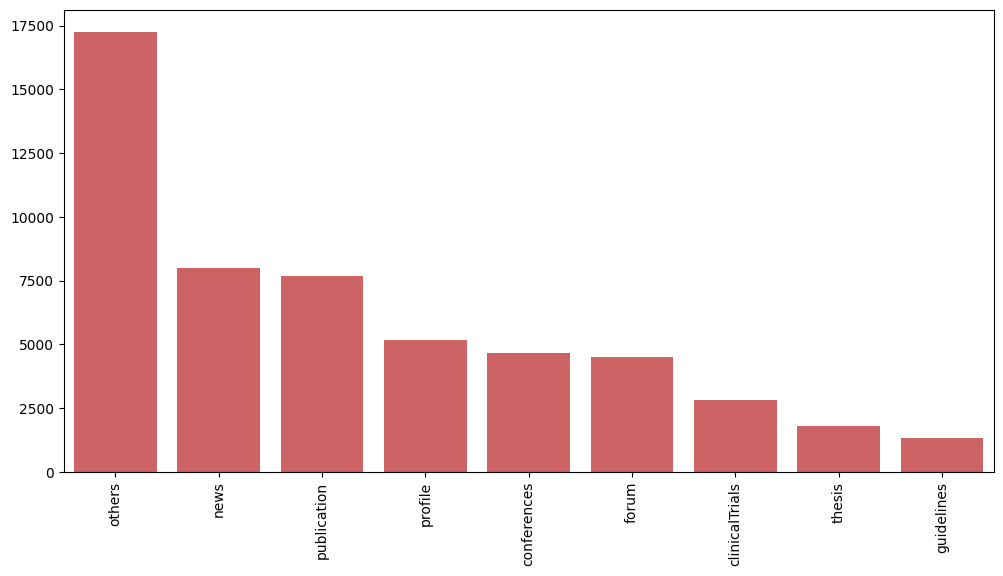

In [ ]:
cnt_tag = df['Tag'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=cnt_tag.index, y=cnt_tag.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

There are 2 major categories apart from others - news and publication. Public profiles, forums and conferences lie in the next bracket.

### [3.3.2] Understanding the common words used in the URLs: WordCloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

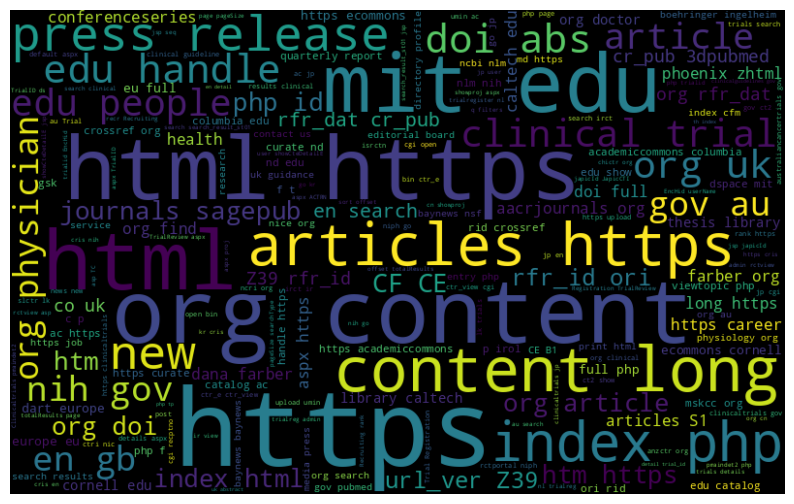

In [ ]:
all_words = ' '.join([text for text in df['Url']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Overall, most of the URLs direct to healthcare pages as can be seen from the word cloud and there are words such as thesis, edu etc. which again imply that frequency of words should be an important feature for prediction.

# **[4] Feature Engineering**

## **[4.1] Variable Identification and Typecasting**

In [ ]:
# A closer look at the data types present in the data
df.dtypes

Webpage_id     int64
Domain        object
Url           object
Tag           object
dtype: object

## **[4.2] Cleaning URL**
Here we simply have domain and URL and these are neither numeric nor categorical variable as each URL is unique

The URLs in the dataset can be considered as a single string since the words in the URL have no spaces. Instead, there are 2 types of separators here '/' and '-'. We can replace these by spaces and we can get individual words this way.

In [ ]:
def clean_url(df):
    df["Url"] = df["Url"].str.replace("/", " ")
    df["Url"] = df["Url"].str.replace("-", " ")
    df["Url"] = df["Url"].str.replace("https:", "")
    df["Url"] = df["Url"].str.replace("http:", "")
    return df

In [ ]:
df = clean_url(df)

In [ ]:
df.head(5)

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,www.fiercepharma.com marketing tecfidera gilenya and aubagio s 3 way battle for ms share about to get more interesting,news
1,2,www.fiercepharma.com,www.fiercepharma.com pharma novo equipped to weather storm u s diabetes market ceo says,news
2,3,www.fiercepharma.com,www.fiercepharma.com pharma another exec departs troubled endo and time it s for another drugmaker,news
3,4,www.fiercepharma.com,www.fiercepharma.com pharma teva buy biosim specialist celltrion it wouldn t say no,news
4,5,www.fiercepharma.com,www.fiercepharma.com marketing actress marissa tomei partners allergan restasis to drive dry eye awareness,news


## **[4.2] Feature Extraction**

Now, that we have tokenised the words and done necessary cleaning. It is time to convert these to features.

### [4.2.1] Bag-of-Words Features

In [ ]:
# Word and character BOW on URLs
vec1 = CountVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_bow = FeatureUnion([("char", vec1), ("word", vec2)])
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

In [ ]:
Url_bow.shape

(53229, 3658)

### [4.2.2] TFIDF Features

In [ ]:
# Word and character TFIDF on URLs
vec1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_tfidf = FeatureUnion([("char", vec1), ("word", vec2)])
vec_tfidf.fit(df['Url'])
Url_tfidf = vec_tfidf.transform(df['Url'])

In [ ]:
Url_tfidf.shape

(53229, 3658)

## **[4.3] Convert tags from strings to numbers**

In [ ]:
TAG_DICT = {"others":1, "news": 2, "publication":3, "profile": 4,
            "conferences": 5, "forum": 6, "clinicalTrials": 7,
            "thesis": 8, "guidelines": 9}

df['target'] = df.Tag.map(TAG_DICT)

# **[5] Model Building**
This is a multi-class classification problem and the metric that we will use here is weighted F1-Score. As discussed in the multi-class module, weighted F1 score basically assigns weights proportional to the class frequency in the train set.

## **[5.1] Test Train Split and Cross Validation**

### Test Train Split

Randomly spliting the dataset into train and test and checking performance will not be correct for this problem. Here's why:

Let's say we have a domain ecommons.cornell.edu. This is basically Cornell University's digital repository and predominantly contain thesis class. Now, if this domain (ecommons.cornell.edu) and class (thesis) combination are contained in both train and test. Just on the basis of domain I can predict the class to be thesis but this model would not be useful and would not generalise well on let's say new thesis by a different domain.

The Solution?


The train and test data split should done based on Domain-Tag combination, such that no 2 URLs for the same class and domain are kept in the train and test respectively because in that case domain can be directly mapped to the tag and that would be a leakage.

In [ ]:
y = df["target"].values

### Model cross Validation

For implementing the above logic. We will use Group K-Fold from Sklearn. In group K-Fold, the same group will not appear in two different folds. The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [ ]:
# Replicate train/test split strategy for cross validation
df["target_str"] = df["Domain"].astype(str) + '_' + df["Tag"].astype(str)
df["target_str"].head(5)

0    www.fiercepharma.com_news
1    www.fiercepharma.com_news
2    www.fiercepharma.com_news
3    www.fiercepharma.com_news
4    www.fiercepharma.com_news
Name: target_str, dtype: object

In [ ]:
cvlist = list(GroupKFold(5).split(df, groups=df["target_str"]))
cvlist

[(array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   35,    36,    37, ..., 53095, 53096, 53097])),
 (array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   92,    93,    94, ..., 52815, 52816, 52817])),
 (array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   34,    39,    55, ..., 53213, 53215, 53216])),
 (array([    0,     1,     2, ..., 53213, 53215, 53216]),
  array([   38,    58,   146, ..., 53226, 53227, 53228])),
 (array([   34,    35,    36, ..., 53226, 53227, 53228]),
  array([    0,     1,     2, ..., 53025, 53026, 53027]))]

In [ ]:
def cv_score(ml_model, df):
    i = 1
    cv_scores = []
    X = df

    # Custom Cross validation based on group KFold
    for df_index,test_index in cvlist:
        print('\n{} of Group kfold {}'.format(i,5))
        xtr,xvl = X[df_index],X[test_index]
        ytr,yvl = y[df_index],y[test_index]

        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        label_preds = np.argmax(pred_probs, axis=1) + 1

        # Calculate scores for each fold and print
        f1_sco = f1_score(yvl, label_preds, average="weighted")
        accuracy = accuracy_score(yvl, label_preds)
        sufix = ""
        msg = ""
        msg += "Weighted F1 Score: {}, Accuracy: {}".format(f1_sco, accuracy)
        print("{}".format(msg))

         # Save scores
        cv_scores.append(f1_score)
        i+=1
    return cv_scores

## **[5.2] Naive Bayes**

### [5.2.1] with Bag-of-Words Features

In [ ]:
MNB_cv_score_bow = cv_score(MultinomialNB(alpha=1), Url_bow)


1 of Group kfold 5
Weighted F1 Score: 0.681413345331894, Accuracy: 0.701484125493143

2 of Group kfold 5
Weighted F1 Score: 0.7155623775116777, Accuracy: 0.7176404283298892

3 of Group kfold 5
Weighted F1 Score: 0.7209173469774105, Accuracy: 0.7307909073830546

4 of Group kfold 5
Weighted F1 Score: 0.740341281405048, Accuracy: 0.7424384745444298

5 of Group kfold 5
Weighted F1 Score: 0.7238173488912508, Accuracy: 0.7315171441991545


### [5.2.2] with TFIDF Features

In [ ]:
MNB_cv_score_tfidf = cv_score(MultinomialNB(alpha=1), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.7053035752103719, Accuracy: 0.7260943077212099

2 of Group kfold 5
Weighted F1 Score: 0.7279158056795141, Accuracy: 0.7345481871125306

3 of Group kfold 5
Weighted F1 Score: 0.7342219501093568, Accuracy: 0.7437535224497464

4 of Group kfold 5
Weighted F1 Score: 0.7642865121563476, Accuracy: 0.7692090926169454

5 of Group kfold 5
Weighted F1 Score: 0.8036624286256433, Accuracy: 0.8015969938938469


## **[5.3] Logistic Regression**

We are getting better performance from TFIDF features. Let's go with that and try logistic regression now. Here, I have used class weight as balanced. This specifically changes the weights of samples inversely proportional to theit frequency meaning the classes which have less number of samples will have more weight.

In [ ]:
lr_cv_score_tfidf = cv_score(LogisticRegression(C=0.1,class_weight="balanced"), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.7001477047644526, Accuracy: 0.7208341160999436

2 of Group kfold 5
Weighted F1 Score: 0.7420657506101059, Accuracy: 0.7465714822468533

3 of Group kfold 5
Weighted F1 Score: 0.7467646471394166, Accuracy: 0.755964681570543

4 of Group kfold 5
Weighted F1 Score: 0.7988550572649397, Accuracy: 0.8013338343039639

5 of Group kfold 5
Weighted F1 Score: 0.7921636915688668, Accuracy: 0.8020666979802724


## **[5.4] Decision Tree**

In [ ]:
dt_cv_score_tfidf = cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.6018865364450445, Accuracy: 0.6346984783017096

2 of Group kfold 5
Weighted F1 Score: 0.628165705299058, Accuracy: 0.6501972571857975

3 of Group kfold 5
Weighted F1 Score: 0.6229122421699438, Accuracy: 0.6338530903625775

4 of Group kfold 5
Weighted F1 Score: 0.6274407848090702, Accuracy: 0.644279541611873

5 of Group kfold 5
Weighted F1 Score: 0.6528728829245739, Accuracy: 0.6618130577736027


## **[5.5] Random Forest**

In [ ]:
rf_params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 50, 'n_jobs': -1}
rf_cv_score_tfidf = cv_score(RandomForestClassifier(**rf_params), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.6606028719369305, Accuracy: 0.6892729663723465

2 of Group kfold 5
Weighted F1 Score: 0.6788263035907093, Accuracy: 0.6984783017095623

3 of Group kfold 5
Weighted F1 Score: 0.6459859779651346, Accuracy: 0.6709562276911516

4 of Group kfold 5
Weighted F1 Score: 0.7276128735459069, Accuracy: 0.7381176028555326

5 of Group kfold 5
Weighted F1 Score: 0.7319454872882054, Accuracy: 0.745608266791921


# **[6] Comparison of Different model fold wise**

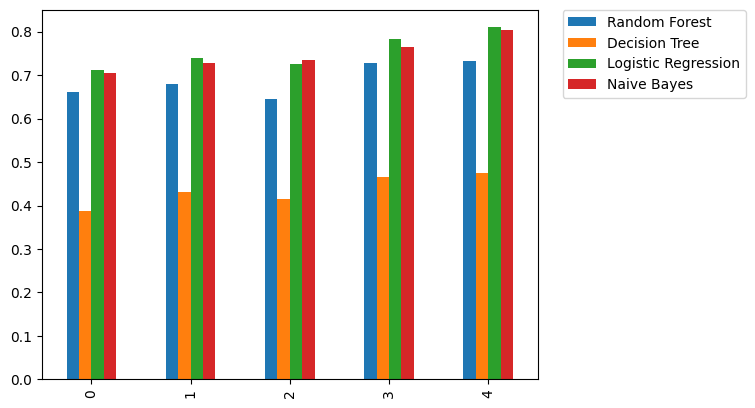

In [ ]:
results_df = pd.DataFrame({'Random Forest':rf_cv_score_tfidf, 'Decision Tree': dt_cv_score_tfidf, 'Logistic Regression': lr_cv_score_tfidf, 'Naive Bayes':MNB_cv_score_tfidf})
results_df.plot(y=["Random Forest", "Decision Tree","Logistic Regression","Naive Bayes"], kind="bar")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Conclusions
* Logistic Regression is getting the best performance.
* Interestingly Tree Based methods are performing badly.